# Cytof data processing

## Requirements

For compatibility, the `numpy` version needs to be fixed:
```bash
pip3 install pandas numpy scprep statsmodels seaborn
```

## Variables definition

In [1]:
# Specify the folder containing the CSV files and the output file name
folder_path = '/Users/romain/Documents/Perso/aure/samples'

#This is a single file containing all conditions. Files have been downloaded from Cytobank as txt files, then concatenated together using R.
normalisation_channel = '165Ho_AlexaFluor488'

# Specify the metadata columns
# metadata_columns = ['Cell_Index', 'Condition', 'Control', 'Replicate', normalisation_channel]
metadata_columns = ['Cell_Index', normalisation_channel]

# Specify other columns to exclude from processing
excluded_columns = []

# Compute the non data columns in a new variable for easier later use
non_data_columns = excluded_columns + metadata_columns

## Import common packages

In [2]:
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 1000)

## Concatenate all files

### Configuration

In [3]:
get_condition_replicate_from_filename = True

### Concatenate

In [ ]:
all_events = pd.DataFrame()

# Loop over all files in folder
for filename in os.listdir(folder_path):
    # Only consider files with '.txt' extension
    if filename.endswith('.txt'):
        # Build the full path to file
        file_path = os.path.join(folder_path, filename)
        # Load the file
        events = pd.read_csv(file_path, delimiter='\t')

        if get_condition_replicate_from_filename:
            # Retrieve metadata from the filename (ex: WGANormalised_Pro_PDO21 + CAFs_01.fcs_file_internal...)
            # First split: ['Pro_AD022_AD_PDO21_OldMG_DMSO_02', '_file_internal']
            # Second split over first element: ['Pro', 'AD022', 'AD', 'PDO21+CAFs', 'OldMG', 'DMSO', '02']

            # Pro_AD022_AD_PDO21+CAFs_OldMG_DMSO_02.fcs_file_internal_comp_PDOs
            metadata_from_filename = filename.split('.fcs')[0].split('_')
            replicate = metadata_from_filename[-1] # 02
            drug = metadata_from_filename[-2] # DMSO
            treatment = metadata_from_filename[-3] # OldMG
            culture = metadata_from_filename[-4] # PDO21+CAFs
            events['Culture'] = culture
            events['Treatment'] = treatment
            # Store the control name in the dataframe: second-to-last element split over '+', and stripped to remove whitespace from both sides
            events['Control'] = culture.split('+')[0].strip()
            # Store the replicate in the dataframe: last element
            events['Replicate'] = replicate # 02
            events['Drug'] = drug # suposed to be DMSO
            # events['Condition'] = culture + '_' + treatment + '_' + replicate
            metadata_columns += ['Culture', 'Treatment', 'Control', 'Replicate', 'Drug']


        # Add the file data to the DataFrame containing all events
        all_events = pd.concat([all_events, events], ignore_index=True)

metadata_columns = list(set(metadata_columns))
# Print all events
initial_all_events = all_events.copy()
all_events

## Data correction

### Loess

In [5]:
import statsmodels.api as sm

# Advantages of Loess-Based Correction
#
# ✅ Handles Non-Linearity: No assumption about the functional form of the relationship.
# ✅ Data-Driven Approach: Adapts to trends within the dataset.
# ✅ Preserves Biological Signal: Corrects only for size effects without distorting underlying biological differences.
#
# Challenges & Considerations
#
# ⚠ Computational Cost: Loess smoothing can be slow for large datasets.
# ⚠ Choosing the Smoothing Parameter (span or frac): Needs tuning to avoid overfitting or underfitting.
# ⚠ Boundary Effects: Can be unstable at extreme values of WGA.
def apply_loess_correction(maker_data, wga_data):
    # Fit Loess model
    lowess_fit = sm.nonparametric.lowess(maker_data, wga_data, frac=0.5)

    # Interpolating fitted values
    # - Column 0 (lowess_fit[:, 0]): The independent variable values (e.g., WGA, the size marker). | WGA values (sorted).
	# - Column 1 (lowess_fit[:, 1]): The corresponding smoothed (Loess-fitted) dependent variable values (e.g., marker intensity). | Loess-smoothed marker intensity values.
    fitted_values = np.interp(wga_data, lowess_fit[:, 0], lowess_fit[:, 1])

    # Return the corrected data
    return maker_data / fitted_values

In [ ]:
# Separate the columns to normalize and the columns to leave as-is
columns_to_normalize = all_events.columns.difference(metadata_columns).tolist()

# Apply Loess correction to each marker column
for marker in columns_to_normalize:
    # cytof_data[f'Corrected_{marker}'] = apply_loess_correction(cytof_data[marker], cytof_data['WGA'])
    all_events[marker] = apply_loess_correction(all_events[marker], all_events[normalisation_channel])

# Filter to keep only rows with all finite values
# all_events = all_events[np.isfinite(all_events).all(axis=1)]

corrected_events = all_events.copy()

all_events

## EMD Generation

### Prepare the data

In [39]:
all_events = initial_all_events.copy()

In [43]:
#drop the metadata to create a df with only numerical data for normalisation/transformation
data = all_events.drop(metadata_columns ,axis=1)
data

,89Y_pHH3_S28_v7,111Cd_Vimentin RV202 v7,112Cd_FAP (1) v3,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v10,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM v2,147Sm_OPTN v2,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v11,151Eu_H3K27me3,153Eu_ANXA1 v2,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v9,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,162Dy_pHistoneH2AX v6,163Dy_H3K9Me3,164Dy_TOP2A (3),167Er_TROP 2(1) v2,168Er_pSMAD2,169Tm_EphB2 v3,170Er_CHGA v3,172Yb_BIRC3 v2,173Yb_pS6,174Yb_cPARP [D214] (2) (v8),176Yb_CyclinB1 (2) (v7),209Bi_Me2HH3[K4]
0,1.584393,0.418837,4.189837,19.285099,4.515055,19.704046,2.191180,230.307327,35.605629,9.743585,16.944330,61.790306,4.139718,1.633933,18.382854,145.235245,236.714355,386.321808,9.061855,10.442521,59.916607,10.845428,684.841248,77.384270,409.888336,42.924000,62.131878,1685.897095,12.608147,14.992565,0.319171,2.927995,3.369709,11.154099,22.246496,13.355079,345.751862
1,3.017946,6.272274,3.032307,70.534752,20.516500,136.379440,0.000000,195.585175,5.574172,0.000000,20.034941,40.319489,0.860810,1.386523,26.911041,36.651764,91.194168,472.673645,11.870360,5.777175,45.021854,0.675073,296.167267,13.795514,211.197113,17.681679,39.814217,52.370209,13.726406,5.592910,16.544731,8.295842,0.012968,40.917576,11.365778,12.686232,59.187855
2,2.554636,2.357155,0.000000,81.673164,5.611413,34.492302,2.145284,283.486115,17.546827,2.703097,20.405190,15.544382,3.805690,4.322140,34.955185,100.695396,112.416878,1512.420532,18.918207,4.761038,45.910698,11.004347,259.088379,149.083008,156.135986,38.235806,46.277397,139.634827,10.319588,8.619646,44.425426,10.490321,5.344706,50.309292,47.308105,25.290604,176.670273
3,5.949113,2.401006,1.704736,673.198486,19.454809,173.299683,0.992192,291.495239,25.090174,22.737280,135.105881,32.194851,16.326599,21.187809,40.987411,156.620712,169.719131,1871.732910,43.036831,29.321232,144.836563,13.375920,596.232849,40.444130,366.806702,44.103706,149.706039,58.399113,47.340092,52.435543,236.212219,48.974850,6.557484,67.555511,65.909027,47.216530,99.228951
4,0.000000,2.473190,0.000000,14.270731,0.088809,12.352245,0.000000,2423.443115,15.420612,8.270519,19.226309,5.217972,2.603921,1.356305,49.881794,89.352081,207.852158,641.911865,4.824018,17.471901,40.624836,6.710595,591.274475,52.068523,361.651276,40.442757,51.305634,437.422089,15.523672,6.171131,0.000000,4.306103,11.690625,77.732605,12.528255,8.840951,174.036865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11436,21.088114,14.545495,7.246308,1772.883057,4.331011,570.573181,13.387660,262.330231,45.811981,249.987549,189.584579,511.076447,64.808128,34.530140,555.716125,1506.146240,725.405212,1990.294678,37.163738,110.246704,411.491974,21.540728,1457.896484,321.899750,729.988831,156.108963,168.514130,1643.549927,81.405991,78.987175,73.896545,45.598289,17.860796,172.766861,348.259949,172.763535,350.359650
11437,0.000000,0.000000,4.624296,229.009018,1.654835,26.144375,0.000000,0.000000,154.391495,3.316871,14.092556,4.841245,1.389978,2.296794,8.680642,2.205429,0.000000,42.650990,5.760919,0.471900,14.787933,0.660469,23.761065,2.723873,8.026617,0.644286,25.638338,9.969074,5.606825,2.432292,11.530819,3.440719,3.478051,8.664199,208.654877,6.529893,1.551513
11438,0.927720,0.000000,3.571215,404.341736,4.613291,63.614311,4.567239,1.515099,17.099911,3.625172,59.739227,67.040070,10.332201,4.905880,31.738789,102.116074,166.417343,349.382080,7.187524,6.585881,35.622421,1.546803,103.772369,11.418908,72.648689,0.000000,21.164253,120.070145,2.607360,0.000000,4.796133,0.000000,0.998121,12.786160,16.430370,14.228437,80.984238
11439,0.911662,0.000000,0.130474,19.481493,3.868013,55.163162,0.691926,0.000000,89.848244,5.037848,16.576801,0.000000,0.054601,2.730725,12.858519,0.816960,0.000000,42.504536,4.659064,0.753616,6.952771,2.414878,7.260062,3.917462,1.016539,24.611

In [44]:
metadata_columns

['Culture',
 'Control',
 'Drug',
 'Replicate',
 '165Ho_AlexaFluor488',
 'Cell_Index',
 'Treatment']

In [45]:
#make sure all metadata columns are strings (not numberical as this will run into errors)
metadata = all_events.filter(metadata_columns)
metadata[metadata_columns] = metadata[metadata_columns].applymap(str)
metadata  

,Culture,Control,Drug,Replicate,165Ho_AlexaFluor488,Cell_Index,Treatment
0,PDO21,PDO21,DMSO,02,189.60777282714844,1,OldMG
1,PDO21,PDO21,DMSO,02,208.4274139404297,2,OldMG
2,PDO21,PDO21,DMSO,02,825.9092407226562,3,OldMG
3,PDO21,PDO21,DMSO,02,1295.28173828125,4,OldMG
4,PDO21,PDO21,DMSO,02,140.42135620117188,5,OldMG
...,...,...,...,...,...,...,...
11436,PDO21+CAFs,PDO21,DMSO,02,4397.33349609375,4236,OldMG
11437,PDO21+CAFs,PDO21,DMSO,02,1174.4039306640625,4237,OldMG
11438,PDO21+CAFs,PDO21,DMSO,02,63.40682220458984,4238,OldMG
11439,PDO21+CAFs,PDO21,DMSO,02,522.1435546875,4239,OldMG


### Select a subset of data (optional)

In [10]:
#Batches:
#Batch 1 = PDO27wt/ko exp B BM/MOPC21/B7C18
#Batch 2 = PDO27 ABCEDF7 Tr
#Batch 3 = PDO27 ABCDEF7 NT
#Batch 4 = PDO21/23/216 ABE7 Tr
#Batch 5 = PDO21/23/216 ABE7 NT 
#Batch 6 = PDO5/11 ABE7 Tr/NT
#Batch 7 = PDO75/99 ABE7 Tr/NT
#Batch 8 = PDO109/141 ABE7 Tr/NT
#Batch 9 = NT/eGFP/eGFP-stIL15 ABE7

#### Configuration

In [46]:
# To enable this process, set this variable to True, False otherwise
should_select_a_subset = False

subset_condition = [True]
if should_select_a_subset:
    # Define here the filter to apply
    subset_condition = \
        metadata['Patient'].isin(['X','5','11','21','23','27','75','99','109','141','216']) & \
        metadata['gd_donor'].isin(['A','B','E','7']) & \
        metadata['Transduction'].isin(['eGFP-stIL15']) & \
        metadata['Treatment'].isin(['BM','B7C18']) & \
        metadata['Batch'].isin(['Batch2','Batch4','Batch6','Batch7','Batch8'])


#### Select the data

In [47]:
if should_select_a_subset:
    #Select eGFP-stIL15 / ABE7 / wt PDO / BM / B7C18 (I was just selecting the data I wanted to use)
    data = data.loc[subset_condition]
    data

#### Select the metadata

In [48]:
if should_select_a_subset:
    #selecting the corresponding metadata
    metadata = metadata.loc[subset_condition]
    metadata

### Arcsinh transformation

#### Configuration

In [49]:
arcsinh_cofactor = 5

#### Data processing

In [50]:
#arcsinh transformation of all raw data
data = np.arcsinh(data/arcsinh_cofactor)
data

,89Y_pHH3_S28_v7,111Cd_Vimentin RV202 v7,112Cd_FAP (1) v3,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v10,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM v2,147Sm_OPTN v2,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v11,151Eu_H3K27me3,153Eu_ANXA1 v2,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v9,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,162Dy_pHistoneH2AX v6,163Dy_H3K9Me3,164Dy_TOP2A (3),167Er_TROP 2(1) v2,168Er_pSMAD2,169Tm_EphB2 v3,170Er_CHGA v3,172Yb_BIRC3 v2,173Yb_pS6,174Yb_cPARP [D214] (2) (v8),176Yb_CyclinB1 (2) (v7),209Bi_Me2HH3[K4]
0,0.311802,0.083670,0.762042,2.059438,0.811103,2.080256,0.425298,4.523242,2.661107,1.420463,1.934733,3.209089,0.754340,0.321233,2.013130,4.062360,4.550675,5.040422,1.356433,1.482529,3.178399,1.516793,5.612910,3.433535,5.099631,2.846515,3.214584,6.513765,1.655234,1.817976,0.063791,0.556437,0.631188,1.542340,2.198290,1.708937,4.929483
1,0.571900,1.050373,0.574358,3.341069,2.119467,3.999486,0.000000,4.359869,0.960289,0.000000,2.096406,2.784367,0.171323,0.273868,2.384766,2.689791,3.597451,5.242142,1.599419,0.987128,2.893927,0.134608,4.774705,1.739384,4.436641,1.975655,2.771853,3.044318,1.734664,0.962789,1.911865,1.279931,0.002594,2.798981,1.559522,1.660976,3.166205
2,0.490964,0.455514,0.000000,3.487370,0.965253,2.629658,0.416877,4.730950,1.968290,0.517245,2.114182,1.852325,0.702034,0.782192,2.642852,3.696425,3.806418,6.405179,2.040857,0.847172,2.913360,1.530020,4.640972,4.088494,4.134693,2.731730,2.921269,4.023060,1.471860,1.312890,2.880673,1.486650,0.929292,3.004359,2.943172,2.323774,4.258195
3,1.009441,0.463434,0.334665,5.595763,2.067922,4.238940,0.197159,4.758806,2.315969,2.219591,3.990110,2.561492,1.899168,2.150775,2.800674,4.137791,4.218071,6.618331,2.849123,2.469213,4.059613,1.710398,5.474358,2.787430,4.988591,2.873451,4.092662,3.152838,2.943844,3.045559,4.548552,2.977612,1.085441,3.298026,3.273420,2.941245,3.681773
4,0.000000,0.476411,0.000000,1.771286,0.017761,1.636200,0.000000,6.876655,1.844718,1.277314,2.056483,0.911866,0.499724,0.268040,2.995868,3.577076,4.420681,5.548175,0.856266,1.964175,2.791855,1.103873,5.466007,3.038567,4.974437,2.787396,3.023876,5.164641,1.851056,1.037701,0.000000,0.779763,1.585375,3.438017,1.649328,1.334887,4.243183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11436,2.146186,1.789302,1.166285,6.564074,0.783533,5.430370,1.711220,4.653404,2.911220,4.605220,4.328718,5.320252,3.256625,2.630743,5.403987,6.401022,5.670452,6.679749,2.703538,3.786944,5.103536,2.166860,6.368462,4.858010,5.676750,4.134520,4.210949,6.488325,3.484100,3.453995,3.387518,2.906572,1.985357,4.235862,4.936710,4.235842,4.942720
11437,0.000000,0.000000,0.827231,4.517590,0.325205,2.356364,0.000000,0.000000,4.123463,0.622404,1.759437,0.858743,0.274534,0.444569,1.318995,0.427907,0.000000,2.840178,0.984998,0.094240,1.804948,0.131713,2.262648,0.520897,1.251801,0.128503,2.337174,1.440866,0.964642,0.469067,1.572733,0.642926,0.649067,1.317352,4.424534,1.082091,0.305527
11438,0.184496,0.000000,0.664296,5.086008,0.825614,3.238089,0.818829,0.298564,1.943502,0.673055,3.175445,3.290387,1.472960,0.868000,2.547396,3.710418,4.198434,4.939927,1.159590,1.088880,2.661574,0.304627,3.726489,1.563793,3.370527,0.000000,2.149693,3.872219,0.500334,0.000000,0.852247,0.000000,0.198322,1.668279,1.905228,1.768485,3.478915
11439,0.181337,0.000000,0.026092,2.069249,0.711922,3.096052,0.137947,0.000000,3.582605,0.886716,1.913719,0.000000,0.010920,0.522100,1.673537,0.162674,0.000000,2.836762,0.832327,0.150158,1.132479,0.465933,1.167846,0.719726,0.201933,2.297086,2.654075,1.298158,0.964702,0.342324,0.503377,1.034732,0.168170,0.474374,3.991126,0.479978,0.568856


### Batch effect correction

In [51]:
import scprep.normalize

# Data centering by batch to correct any cytof batch effect
# Only if 'Batch' is a metadata
if 'Batch' in metadata.columns:
    data = scprep.normalize.batch_mean_center(data,sample_idx=metadata['Batch'])
    data

### Re-assemble processed data with metadata

#### Concatenate data with metadata

In [52]:
# Combine arcsinh-transformed and mean-centered data with metadata again
processed_data = pd.concat([data, metadata], axis=1)
processed_data

,89Y_pHH3_S28_v7,111Cd_Vimentin RV202 v7,112Cd_FAP (1) v3,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v10,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM v2,147Sm_OPTN v2,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v11,151Eu_H3K27me3,153Eu_ANXA1 v2,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v9,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,162Dy_pHistoneH2AX v6,163Dy_H3K9Me3,164Dy_TOP2A (3),167Er_TROP 2(1) v2,168Er_pSMAD2,169Tm_EphB2 v3,170Er_CHGA v3,172Yb_BIRC3 v2,173Yb_pS6,174Yb_cPARP [D214] (2) (v8),176Yb_CyclinB1 (2) (v7),209Bi_Me2HH3[K4],Culture,Control,Drug,Replicate,165Ho_AlexaFluor488,Cell_Index,Treatment
0,0.311802,0.083670,0.762042,2.059438,0.811103,2.080256,0.425298,4.523242,2.661107,1.420463,1.934733,3.209089,0.754340,0.321233,2.013130,4.062360,4.550675,5.040422,1.356433,1.482529,3.178399,1.516793,5.612910,3.433535,5.099631,2.846515,3.214584,6.513765,1.655234,1.817976,0.063791,0.556437,0.631188,1.542340,2.198290,1.708937,4.929483,PDO21,PDO21,DMSO,02,189.60777282714844,1,OldMG
1,0.571900,1.050373,0.574358,3.341069,2.119467,3.999486,0.000000,4.359869,0.960289,0.000000,2.096406,2.784367,0.171323,0.273868,2.384766,2.689791,3.597451,5.242142,1.599419,0.987128,2.893927,0.134608,4.774705,1.739384,4.436641,1.975655,2.771853,3.044318,1.734664,0.962789,1.911865,1.279931,0.002594,2.798981,1.559522,1.660976,3.166205,PDO21,PDO21,DMSO,02,208.4274139404297,2,OldMG
2,0.490964,0.455514,0.000000,3.487370,0.965253,2.629658,0.416877,4.730950,1.968290,0.517245,2.114182,1.852325,0.702034,0.782192,2.642852,3.696425,3.806418,6.405179,2.040857,0.847172,2.913360,1.530020,4.640972,4.088494,4.134693,2.731730,2.921269,4.023060,1.471860,1.312890,2.880673,1.486650,0.929292,3.004359,2.943172,2.323774,4.258195,PDO21,PDO21,DMSO,02,825.9092407226562,3,OldMG
3,1.009441,0.463434,0.334665,5.595763,2.067922,4.238940,0.197159,4.758806,2.315969,2.219591,3.990110,2.561492,1.899168,2.150775,2.800674,4.137791,4.218071,6.618331,2.849123,2.469213,4.059613,1.710398,5.474358,2.787430,4.988591,2.873451,4.092662,3.152838,2.943844,3.045559,4.548552,2.977612,1.085441,3.298026,3.273420,2.941245,3.681773,PDO21,PDO21,DMSO,02,1295.28173828125,4,OldMG
4,0.000000,0.476411,0.000000,1.771286,0.017761,1.636200,0.000000,6.876655,1.844718,1.277314,2.056483,0.911866,0.499724,0.268040,2.995868,3.577076,4.420681,5.548175,0.856266,1.964175,2.791855,1.103873,5.466007,3.038567,4.974437,2.787396,3.023876,5.164641,1.851056,1.037701,0.000000,0.779763,1.585375,3.438017,1.649328,1.334887,4.243183,PDO21,PDO21,DMSO,02,140.42135620117188,5,OldMG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11436,2.146186,1.789302,1.166285,6.564074,0.783533,5.430370,1.711220,4.653404,2.911220,4.605220,4.328718,5.320252,3.256625,2.630743,5.403987,6.401022,5.670452,6.679749,2.703538,3.786944,5.103536,2.166860,6.368462,4.858010,5.676750,4.134520,4.210949,6.488325,3.484100,3.453995,3.387518,2.906572,1.985357,4.235862,4.936710,4.235842,4.942720,PDO21+CAFs,PDO21,DMSO,02,4397.33349609375,4236,OldMG
11437,0.000000,0.000000,0.827231,4.517590,0.325205,2.356364,0.000000,0.000000,4.123463,0.622404,1.759437,0.858743,0.274534,0.444569,1.318995,0.427907,0.000000,2.840178,0.984998,0.094240,1.804948,0.131713,2.262648,0.520897,1.251801,0.128503,2.337174,1.440866,0.964642,0.469067,1.572733,0.642926,0.649067,1.317352,4.424534,1.082091,0.305527,PDO21+CAFs,PDO21,DMSO,02,1174.4039306640625,4237,OldMG
11438,0.184496,0.000000,0.664296,5.086008,0.825614,3.238089,0.818829,0.298564,1.943502,0.673055,3.175445,3.290387,1.472960,0.868000,2.547396,3.710418,4.198434,4.939927,1.159590,1.088880,2.661574,0.304627,3.726489,1.563793,3.370527,0.000000,2.149693,3.872219,0.500334,0.000000,0.852247,0.000000,0.198322,1.668279,1.905228,1.768485,3.478915,PDO21+CAFs,PDO21,DMSO,02,63.40682220458984,4238,OldMG
11439,0.181337,0.000000,0

#### Re-index the Dataframe

In [53]:
row_count = processed_data.shape[0]
processed_data.index = np.arange(row_count)

#### Ensure type of metadata column to be string

In [54]:

processed_data[metadata_columns] = processed_data[metadata_columns].applymap(str)
processed_data

,89Y_pHH3_S28_v7,111Cd_Vimentin RV202 v7,112Cd_FAP (1) v3,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v10,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM v2,147Sm_OPTN v2,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v11,151Eu_H3K27me3,153Eu_ANXA1 v2,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v9,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,162Dy_pHistoneH2AX v6,163Dy_H3K9Me3,164Dy_TOP2A (3),167Er_TROP 2(1) v2,168Er_pSMAD2,169Tm_EphB2 v3,170Er_CHGA v3,172Yb_BIRC3 v2,173Yb_pS6,174Yb_cPARP [D214] (2) (v8),176Yb_CyclinB1 (2) (v7),209Bi_Me2HH3[K4],Culture,Control,Drug,Replicate,165Ho_AlexaFluor488,Cell_Index,Treatment
0,0.311802,0.083670,0.762042,2.059438,0.811103,2.080256,0.425298,4.523242,2.661107,1.420463,1.934733,3.209089,0.754340,0.321233,2.013130,4.062360,4.550675,5.040422,1.356433,1.482529,3.178399,1.516793,5.612910,3.433535,5.099631,2.846515,3.214584,6.513765,1.655234,1.817976,0.063791,0.556437,0.631188,1.542340,2.198290,1.708937,4.929483,PDO21,PDO21,DMSO,02,189.60777282714844,1,OldMG
1,0.571900,1.050373,0.574358,3.341069,2.119467,3.999486,0.000000,4.359869,0.960289,0.000000,2.096406,2.784367,0.171323,0.273868,2.384766,2.689791,3.597451,5.242142,1.599419,0.987128,2.893927,0.134608,4.774705,1.739384,4.436641,1.975655,2.771853,3.044318,1.734664,0.962789,1.911865,1.279931,0.002594,2.798981,1.559522,1.660976,3.166205,PDO21,PDO21,DMSO,02,208.4274139404297,2,OldMG
2,0.490964,0.455514,0.000000,3.487370,0.965253,2.629658,0.416877,4.730950,1.968290,0.517245,2.114182,1.852325,0.702034,0.782192,2.642852,3.696425,3.806418,6.405179,2.040857,0.847172,2.913360,1.530020,4.640972,4.088494,4.134693,2.731730,2.921269,4.023060,1.471860,1.312890,2.880673,1.486650,0.929292,3.004359,2.943172,2.323774,4.258195,PDO21,PDO21,DMSO,02,825.9092407226562,3,OldMG
3,1.009441,0.463434,0.334665,5.595763,2.067922,4.238940,0.197159,4.758806,2.315969,2.219591,3.990110,2.561492,1.899168,2.150775,2.800674,4.137791,4.218071,6.618331,2.849123,2.469213,4.059613,1.710398,5.474358,2.787430,4.988591,2.873451,4.092662,3.152838,2.943844,3.045559,4.548552,2.977612,1.085441,3.298026,3.273420,2.941245,3.681773,PDO21,PDO21,DMSO,02,1295.28173828125,4,OldMG
4,0.000000,0.476411,0.000000,1.771286,0.017761,1.636200,0.000000,6.876655,1.844718,1.277314,2.056483,0.911866,0.499724,0.268040,2.995868,3.577076,4.420681,5.548175,0.856266,1.964175,2.791855,1.103873,5.466007,3.038567,4.974437,2.787396,3.023876,5.164641,1.851056,1.037701,0.000000,0.779763,1.585375,3.438017,1.649328,1.334887,4.243183,PDO21,PDO21,DMSO,02,140.42135620117188,5,OldMG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11436,2.146186,1.789302,1.166285,6.564074,0.783533,5.430370,1.711220,4.653404,2.911220,4.605220,4.328718,5.320252,3.256625,2.630743,5.403987,6.401022,5.670452,6.679749,2.703538,3.786944,5.103536,2.166860,6.368462,4.858010,5.676750,4.134520,4.210949,6.488325,3.484100,3.453995,3.387518,2.906572,1.985357,4.235862,4.936710,4.235842,4.942720,PDO21+CAFs,PDO21,DMSO,02,4397.33349609375,4236,OldMG
11437,0.000000,0.000000,0.827231,4.517590,0.325205,2.356364,0.000000,0.000000,4.123463,0.622404,1.759437,0.858743,0.274534,0.444569,1.318995,0.427907,0.000000,2.840178,0.984998,0.094240,1.804948,0.131713,2.262648,0.520897,1.251801,0.128503,2.337174,1.440866,0.964642,0.469067,1.572733,0.642926,0.649067,1.317352,4.424534,1.082091,0.305527,PDO21+CAFs,PDO21,DMSO,02,1174.4039306640625,4237,OldMG
11438,0.184496,0.000000,0.664296,5.086008,0.825614,3.238089,0.818829,0.298564,1.943502,0.673055,3.175445,3.290387,1.472960,0.868000,2.547396,3.710418,4.198434,4.939927,1.159590,1.088880,2.661574,0.304627,3.726489,1.563793,3.370527,0.000000,2.149693,3.872219,0.500334,0.000000,0.852247,0.000000,0.198322,1.668279,1.905228,1.768485,3.478915,PDO21+CAFs,PDO21,DMSO,02,63.40682220458984,4238,OldMG
11439,0.181337,0.000000,0

### Store the `Condition` information (optional)

#### Configuration

In [55]:
condition_colmns = ['Culture', 'Treatment', 'Drug', 'Replicate']

#### Generate the `Condition` column

In [56]:
if 'Condition' not in metadata.columns:
    # Create a condition column for every cell in the experiment
    processed_data['Condition'] = processed_data[condition_colmns].astype(str).agg('_'.join, axis=1)

    # Add `Condition` to the list of metadata columns
    metadata_columns += ['Condition']

processed_data

,89Y_pHH3_S28_v7,111Cd_Vimentin RV202 v7,112Cd_FAP (1) v3,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v10,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM v2,147Sm_OPTN v2,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v11,151Eu_H3K27me3,153Eu_ANXA1 v2,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v9,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,162Dy_pHistoneH2AX v6,163Dy_H3K9Me3,164Dy_TOP2A (3),167Er_TROP 2(1) v2,168Er_pSMAD2,169Tm_EphB2 v3,170Er_CHGA v3,172Yb_BIRC3 v2,173Yb_pS6,174Yb_cPARP [D214] (2) (v8),176Yb_CyclinB1 (2) (v7),209Bi_Me2HH3[K4],Culture,Control,Drug,Replicate,165Ho_AlexaFluor488,Cell_Index,Treatment,Condition
0,0.311802,0.083670,0.762042,2.059438,0.811103,2.080256,0.425298,4.523242,2.661107,1.420463,1.934733,3.209089,0.754340,0.321233,2.013130,4.062360,4.550675,5.040422,1.356433,1.482529,3.178399,1.516793,5.612910,3.433535,5.099631,2.846515,3.214584,6.513765,1.655234,1.817976,0.063791,0.556437,0.631188,1.542340,2.198290,1.708937,4.929483,PDO21,PDO21,DMSO,02,189.60777282714844,1,OldMG,PDO21_OldMG_DMSO_02
1,0.571900,1.050373,0.574358,3.341069,2.119467,3.999486,0.000000,4.359869,0.960289,0.000000,2.096406,2.784367,0.171323,0.273868,2.384766,2.689791,3.597451,5.242142,1.599419,0.987128,2.893927,0.134608,4.774705,1.739384,4.436641,1.975655,2.771853,3.044318,1.734664,0.962789,1.911865,1.279931,0.002594,2.798981,1.559522,1.660976,3.166205,PDO21,PDO21,DMSO,02,208.4274139404297,2,OldMG,PDO21_OldMG_DMSO_02
2,0.490964,0.455514,0.000000,3.487370,0.965253,2.629658,0.416877,4.730950,1.968290,0.517245,2.114182,1.852325,0.702034,0.782192,2.642852,3.696425,3.806418,6.405179,2.040857,0.847172,2.913360,1.530020,4.640972,4.088494,4.134693,2.731730,2.921269,4.023060,1.471860,1.312890,2.880673,1.486650,0.929292,3.004359,2.943172,2.323774,4.258195,PDO21,PDO21,DMSO,02,825.9092407226562,3,OldMG,PDO21_OldMG_DMSO_02
3,1.009441,0.463434,0.334665,5.595763,2.067922,4.238940,0.197159,4.758806,2.315969,2.219591,3.990110,2.561492,1.899168,2.150775,2.800674,4.137791,4.218071,6.618331,2.849123,2.469213,4.059613,1.710398,5.474358,2.787430,4.988591,2.873451,4.092662,3.152838,2.943844,3.045559,4.548552,2.977612,1.085441,3.298026,3.273420,2.941245,3.681773,PDO21,PDO21,DMSO,02,1295.28173828125,4,OldMG,PDO21_OldMG_DMSO_02
4,0.000000,0.476411,0.000000,1.771286,0.017761,1.636200,0.000000,6.876655,1.844718,1.277314,2.056483,0.911866,0.499724,0.268040,2.995868,3.577076,4.420681,5.548175,0.856266,1.964175,2.791855,1.103873,5.466007,3.038567,4.974437,2.787396,3.023876,5.164641,1.851056,1.037701,0.000000,0.779763,1.585375,3.438017,1.649328,1.334887,4.243183,PDO21,PDO21,DMSO,02,140.42135620117188,5,OldMG,PDO21_OldMG_DMSO_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11436,2.146186,1.789302,1.166285,6.564074,0.783533,5.430370,1.711220,4.653404,2.911220,4.605220,4.328718,5.320252,3.256625,2.630743,5.403987,6.401022,5.670452,6.679749,2.703538,3.786944,5.103536,2.166860,6.368462,4.858010,5.676750,4.134520,4.210949,6.488325,3.484100,3.453995,3.387518,2.906572,1.985357,4.235862,4.936710,4.235842,4.942720,PDO21+CAFs,PDO21,DMSO,02,4397.33349609375,4236,OldMG,PDO21+CAFs_OldMG_DMSO_02
11437,0.000000,0.000000,0.827231,4.517590,0.325205,2.356364,0.000000,0.000000,4.123463,0.622404,1.759437,0.858743,0.274534,0.444569,1.318995,0.427907,0.000000,2.840178,0.984998,0.094240,1.804948,0.131713,2.262648,0.520897,1.251801,0.128503,2.337174,1.440866,0.964642,0.469067,1.572733,0.642926,0.649067,1.317352,4.424534,1.082091,0.305527,PDO21+CAFs,PDO21,DMSO,02,1174.4039306640625,4237,OldMG,PDO21+CAFs_OldMG_DMSO_02
11438,0.184496,0.000000,0.664296,5.086008,0.825614,3.238089,0.818829,0.298564,1.943502,0.673055,3.175445,3.290387,1.472960,0.868000,2.547396,3.710418,4.198434,4.939927,1.159590,1.088880,2.661574,0.304627,3.726489,1.563793,3.370527,0.000000,2.149693,3.872

### Store the `Control` information (optional)

#### Configuration

In [22]:
# All gd monoculture controls including their transduction, treatment and batch.
control_columns = ['gd_donor', 'Transduction', 'Treatment', 'Batch', 'Date']

#### Generate the `Control` column

In [ ]:
if 'Control' not in metadata.columns:
    # Define control for pairwise EMD. 
    processed_data['Control'] = "X_gd_" + processed_data[control_columns].astype(str).agg('_'.join, axis=1)

    # Add `Control` to the list of metadata columns
    metadata_columns += 'Control'

processed_data

### Save processed data to file (optional)

In [25]:
processed_data.to_csv(folder_path + '/processed_data.bkp', index=False, sep='\t')

### Initialise EMD dataframe

#### Compute the markers list

In [57]:
# For each column in the Dataframe, keep only the ones not in the `metadata_columns` variable
markers_list = [col for col in processed_data.columns if col not in metadata_columns]
# marker_list = list(processed_data.columns.values)
markers_list

['89Y_pHH3_S28_v7',
 '111Cd_Vimentin RV202 v7',
 '112Cd_FAP (1) v3',
 '113In_CD326 (EpCAM) (hu) (v6)',
 '114Cd_CK18 (v6)',
 '115In_Pan-CK_v10',
 '116Cd_GFP_v4',
 '127I_IdU',
 '142Nd_cCaspase 3_D175_v6',
 '143Nd_RRM2',
 '144Nd_SOX2 v2',
 '145Nd_pNDRG1 T346 v4',
 '146Nd_L1CAM v2',
 '147Sm_OPTN v2',
 '148Nd_CDK1 (1)',
 '149Sm_p4E-BP1_T37',
 '150Nd_pRB_S807_S811_v11',
 '151Eu_H3K27me3',
 '153Eu_ANXA1 v2',
 '155Gd_pAKT [S473] v12',
 '156Gd_pNF-kB p65 v9',
 '157Gd_MOPC21',
 '158Gd_pP38 MAPK v7',
 '160Gd_KI67(3)',
 '161Dy_pLATS1',
 '162Dy_pHistoneH2AX v6',
 '163Dy_H3K9Me3',
 '164Dy_TOP2A (3)',
 '167Er_TROP 2(1) v2',
 '168Er_pSMAD2',
 '169Tm_EphB2 v3',
 '170Er_CHGA v3',
 '172Yb_BIRC3 v2',
 '173Yb_pS6',
 '174Yb_cPARP [D214] (2) (v8)',
 '176Yb_CyclinB1 (2) (v7)',
 '209Bi_Me2HH3[K4]']

#### Compute the conditions list

In [58]:
# Get the list of unique conditions
conditions_list = pd.unique(processed_data['Condition'].tolist())
conditions_list

# pdo21 et pdo21+caf

array(['PDO21_OldMG_DMSO_02', 'PDO21+CAFs_OldMG_DMSO_02'], dtype=object)

#### Compute the controls list (unused)

In [ ]:
# Get the list of unique controls
controls_list = pd.unique(processed_data['Control'].tolist())
controls_list

#### Create the DataFrame that will receive the EMD values

In [59]:
# Empty df with NaN values to populate with the EMD values
emd_dataframe = pd.DataFrame(
    np.full(
        (len(conditions_list), len(markers_list)), 
        np.nan),
    columns = markers_list,
    index = conditions_list)


### Calculate EMD scores

In [60]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scprep.stats

# Precompute control dataframes for each control name
control_data = {
    control: processed_data.loc[processed_data["Condition"].str.startswith(control)].copy()
    for control in processed_data['Control'].unique()
}

# Function to process a single (condition, marker) pair
def process_condition_marker(condition, marker):
    # Dataframe of all events for the condition in the list
    condition_events = processed_data.loc[processed_data["Condition"] == condition].copy()
    control_name = condition_events['Control'].values[0]
    # Dataframe of all events from the control that will be compared with the events of the current condition
    control_df = control_data[control_name].copy()
    
    condition_median = condition_events[marker].median()
    control_median = control_df[marker].median()

    # Check the sign by using the `median` values
    sign = np.sign(condition_median - control_median)
    
    # Fall back to mean if medians are equal
    if sign == 0:
        sign = np.sign(
            condition_events[marker].mean() - control_df[marker].mean()
        )
    
    # Compute the EMD
    emd = scprep.stats.EMD(condition_events[marker], control_df[marker])
    return (condition, marker, sign * emd)

# Use joblib to parallelize
results = Parallel(n_jobs=-1, backend='loky')(  
    # n_jobs=-1: Use all available cores
    # backend='loky': Loky backend for robust parallelization
    delayed(process_condition_marker)(condition, marker)
    for condition in conditions_list
    for marker in markers_list
)

# Convert results into a DataFrame
emd_dataframe = (
    pd.DataFrame(results, columns=['Condition', 'Marker', 'Signed EMD'])
    .pivot(index='Condition', columns='Marker', values='Signed EMD')
)


In [ ]:
emd_dataframe.T

### Save EMD to file

In [ ]:
emd_dataframe.to_csv(folder_path + '/events_emd.bkp', index=True, sep='\t')
emd_dataframe

## Generate Heatmap

### Configure

In [ ]:
# import numpy as np
# import pandas as pd
# import plotly.express as px
import matplotlib.pyplot as plt
# %matplotlib inline

# import phate
# import matplotlib
# import matplotlib.colors as mcolors
# import scprep
# import os
# import scipy
import seaborn as sns
# from scipy.stats.stats import pearsonr
# from sklearn.decomposition import PCA

# generate custom colour palette for seaborn heatmaps

import matplotlib.colors as mcolors

# Define custom colormap with white at zero
custom_diverging = mcolors.LinearSegmentedColormap.from_list("",["#6f00ff", "white", "#ef3038"], N=256)

### Draw

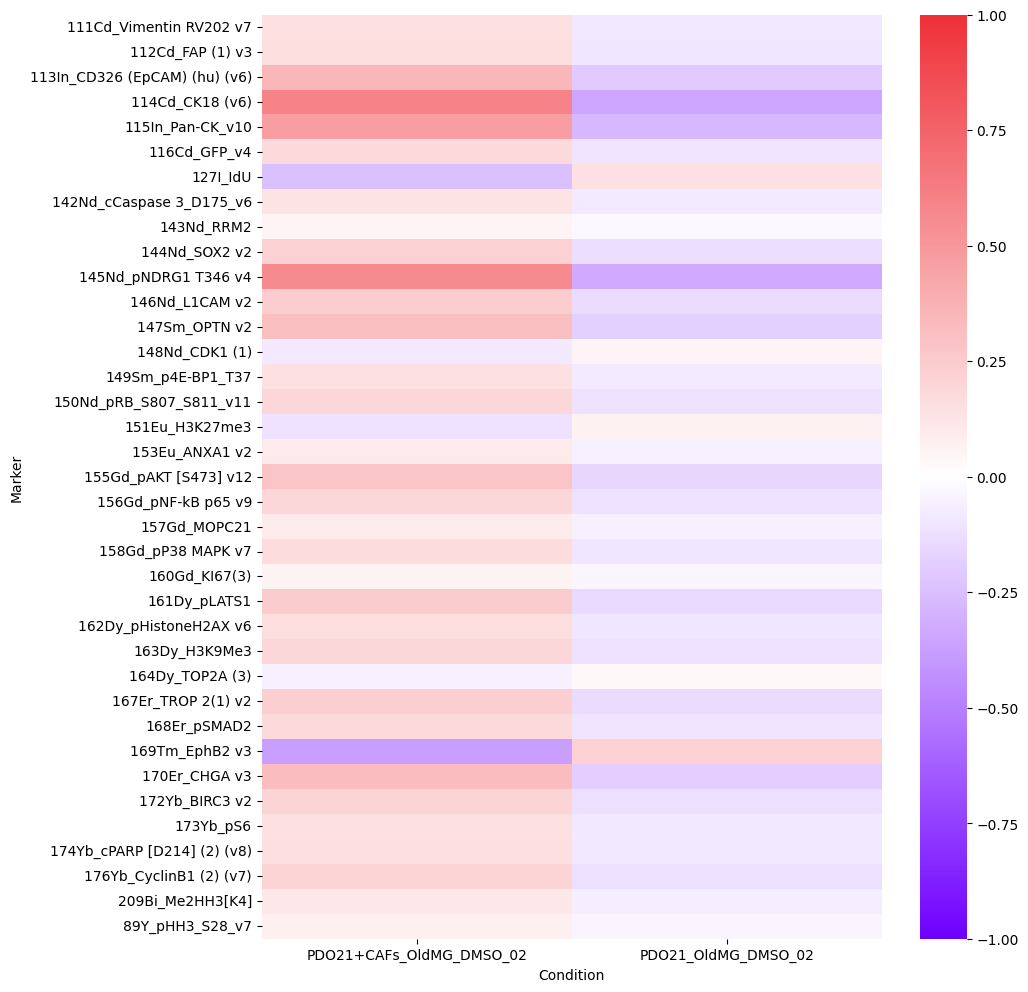

In [61]:
fig, ax = plt.subplots(figsize=(10, 12))

offset = mcolors.TwoSlopeNorm(vmin=-1 ,vcenter=0, vmax=1)

sns.heatmap(emd_dataframe.T, cmap=custom_diverging, norm=offset, )

plt.savefig(folder_path + '/emd_all_global.png', dpi=900, transparent=True)
plt.show()